In [1]:
from brian2 import *
%matplotlib inline
import numpy as np
from numpy import heaviside
from math import *
import pandas as pd
from numba import jit
from matplotlib import cm

@jit
# Potential function
def U(phi,I=1.01,gamma=1,T=4.615120516841259, tau=1):
    value = (I/gamma)*(1-np.exp(-gamma*T*phi/tau))
    return value
@jit
# Function to convert potential to 'phase' corresponding to Mirollo-Strogatz model
def U_inv(y,I=1.01,gamma=1,T=4.615120516841259,tau=1):
    value = (tau/(gamma*T))*np.log((1-(gamma*y/I))**(-1))
    return value
## Loading Inhibitory and Excitatory Edge topology from a 81 × 81 Matrix specifying 20 connections for each neuron 
# Import Sudoku matrices: (rows: pre-synaptic, columns: post-synaptic)

inhib_connect = np.loadtxt('Clueless_Sudoku_inhib.txt', dtype=int)
excit_connect = np.loadtxt('Clueless_Sudoku_excit.txt', dtype=int)

# Get tuples of corresponding connection indices for putting in Brian2's synapse connect() function
inhib_pre, inhib_post = inhib_connect.nonzero()
excit_pre, excit_post = excit_connect.nonzero()

In [16]:
start_scope()
N = 81                          # No. of neurons
tau = 10*ms                     # Time constant of neuron
A_osc = 0.2                     # Oscillation amplitude #?
freq = 25*Hz                    # Frequency of common oscillatory drive #?
transm_delay = pow(10,-5)*ms    # Delay between firing and reception of pulse by post-synaptic neuron

defaultclock.dt=0.1*ms

# Pulse strengths: inhibitory and excitatory
C_inh = -2.7*pow(10,-1)
C_exc = +2.8*pow(10,-6)

eqs = '''
dv/dt = (I+Ib-v)/tau : 1
phase = (freq*t) % 1.0 : 1
I = 30 : 1
Ib : 1
'''
# Create a neuron group 'G' following the above equation
G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='euler')
G.v = 'rand()' 
G.Ib=0


# Inhibitory synapses
S_inhib = Synapses(G,G, on_pre='v_post += C_inh', delay=transm_delay)
S_inhib.connect(i=inhib_pre, j=inhib_post)

# Excitatory synapses
S_excit = Synapses(G,G, on_pre='v_post += C_exc', delay=transm_delay)
S_excit.connect(i=excit_pre, j=excit_post)

# Record of potential for all neurons
potential = StateMonitor(G, 'v', record=True)
# Record of oscillatory drive (common to all neurons)
osc = StateMonitor(G, "I", record=0)
# Record of all spikes
firing_time = SpikeMonitor(G)
t=10000
run(t*ms)
I = (str(list(G.I.__dict__.values())[1]))[86:88]


In [4]:
runnum='noPhase'

In [5]:
import os
script_dir = os.path.dirname('DC Only.ipynb')
results_dir = os.path.join(script_dir, '26mVDCInput_Results/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

plt.savefig(results_dir +str(runnum)+'intial')

<Figure size 432x288 with 0 Axes>

In [6]:
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

csfont = {'fontname':'sans-serif'}
hfont = {'fontname':'serif'}
rcParams.update({'font.family':'serif'})
rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)

No handles with labels found to put in legend.


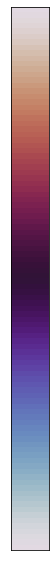

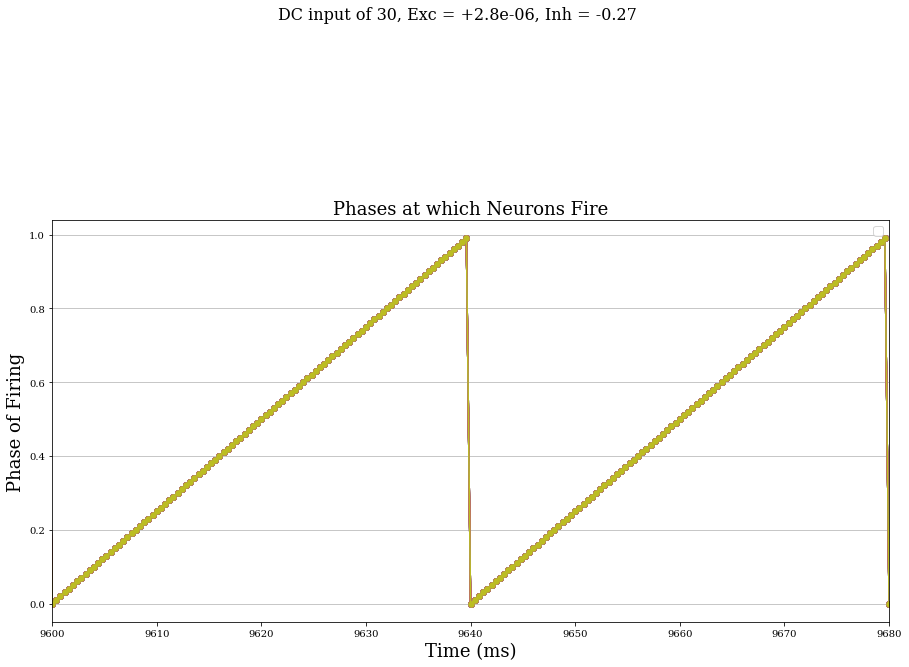

In [7]:
# Plot the final phases of firing of neurons at the end of the simulation
# Plot the final phases of firing of neurons at the end of the simulation
fig = figure(figsize=(15,10))
gs2 = fig.add_gridspec(1,40)
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
           'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

ph_color = fig.add_subplot(gs2[:,:2])
phase_array = np.array( [ list(np.arange(0,1.01,0.01)) for i in range(5) ] ).T
ph_color.pcolormesh(np.arange(5),np.arange(0,1.01,0.01), phase_array[:-1,:-1], cmap=cm.get_cmap('twilight'))
ph_color.set_xticks([])
ph_color.set_yticks([])


fig = figure(figsize=(15,10))

gs = fig.add_gridspec(4,1)
ax=fig.add_subplot(gs[1:,:])
ax.grid(True, 'both','y',linewidth=0.7)

title('Phases at which Neurons Fire', fontsize=18)
suptitle('DC input of '+str(I) +', Exc = +'+str(C_exc) + ', '+ 'Inh = ' + str(C_inh),**hfont,fontsize=16)
for i in range(N):
    ax.plot(firing_time.values('t')[i]/ms, firing_time.values('phase')[i], '.-',mew=3,markersize=7)

plt.rc('xtick', labelsize=10)  
ylim=(0.15,0.45)
ax.set_xlim(9600,9680)
xlabel('Time (ms)',**hfont,fontsize=18)
ylabel('Phase of Firing',**hfont,fontsize=18)
legend(loc='upper right', fontsize='large')
savefig(results_dir +str(runnum)+ 'Directed End Phases of Firing.png',dpi=120)
show()

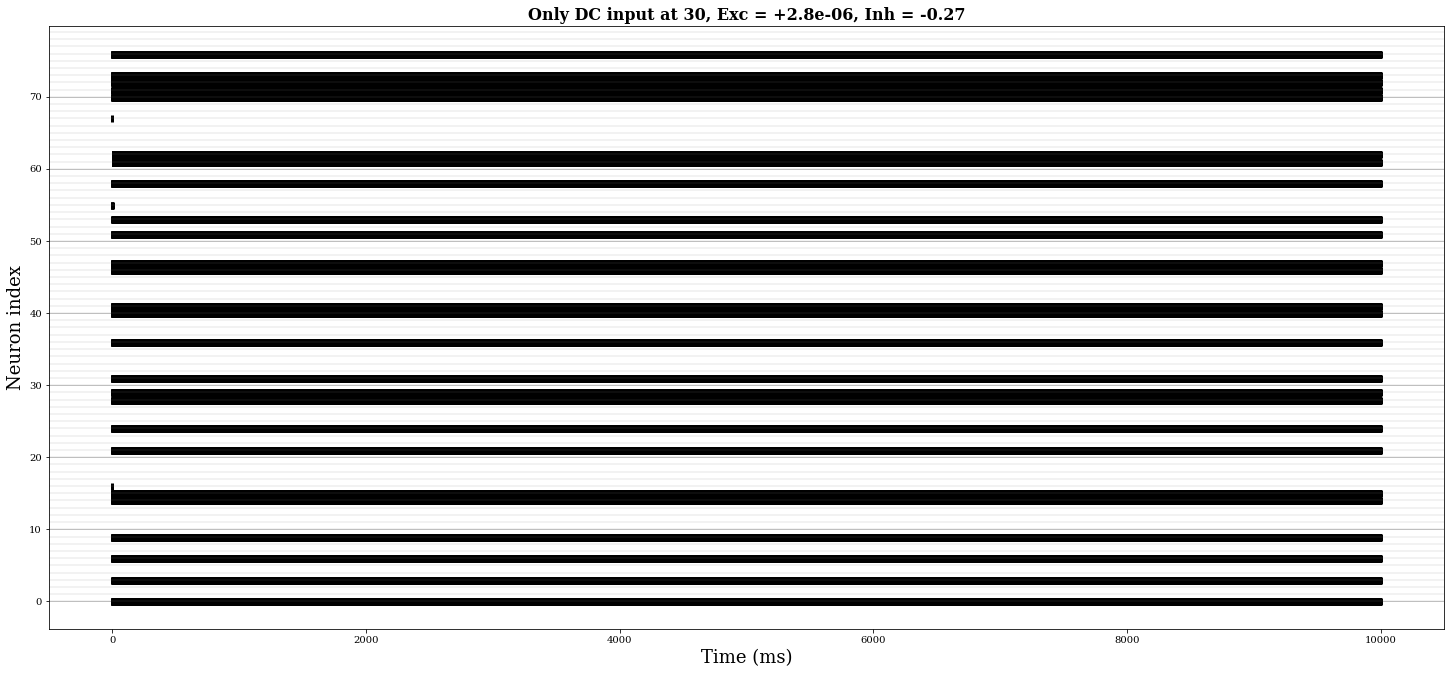

In [17]:
fig = figure(figsize=(25,15))
#x_lim = (3950,3990)

gs = fig.add_gridspec(4,1)
ax=fig.add_subplot(gs[1:,:])
ax.plot(firing_time.t/ms, firing_time.i,'|k', markerfacecolor='xkcd:salmon', mew=3,markersize=7)
#ax.set_xlim(x_lim)
ax.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    ax.axhline(y=i, linewidth=0.2, color='gray')
csfont = {'fontname':'sans-serif'}
hfont = {'fontname':'serif'}
plt.rc('xtick', labelsize=10)
xlabel('Time (ms)',**hfont,fontsize=18)
ylabel('Neuron index',**hfont,fontsize=18)
title('Only DC input at '+str(I) +', '+'Exc = +'+str(C_exc) + ', '+ 'Inh = ' + str(C_inh), fontsize=16,**hfont,fontweight="bold")
plt.savefig(results_dir +str(runnum)+ 'Full Raster plot.png')
show()


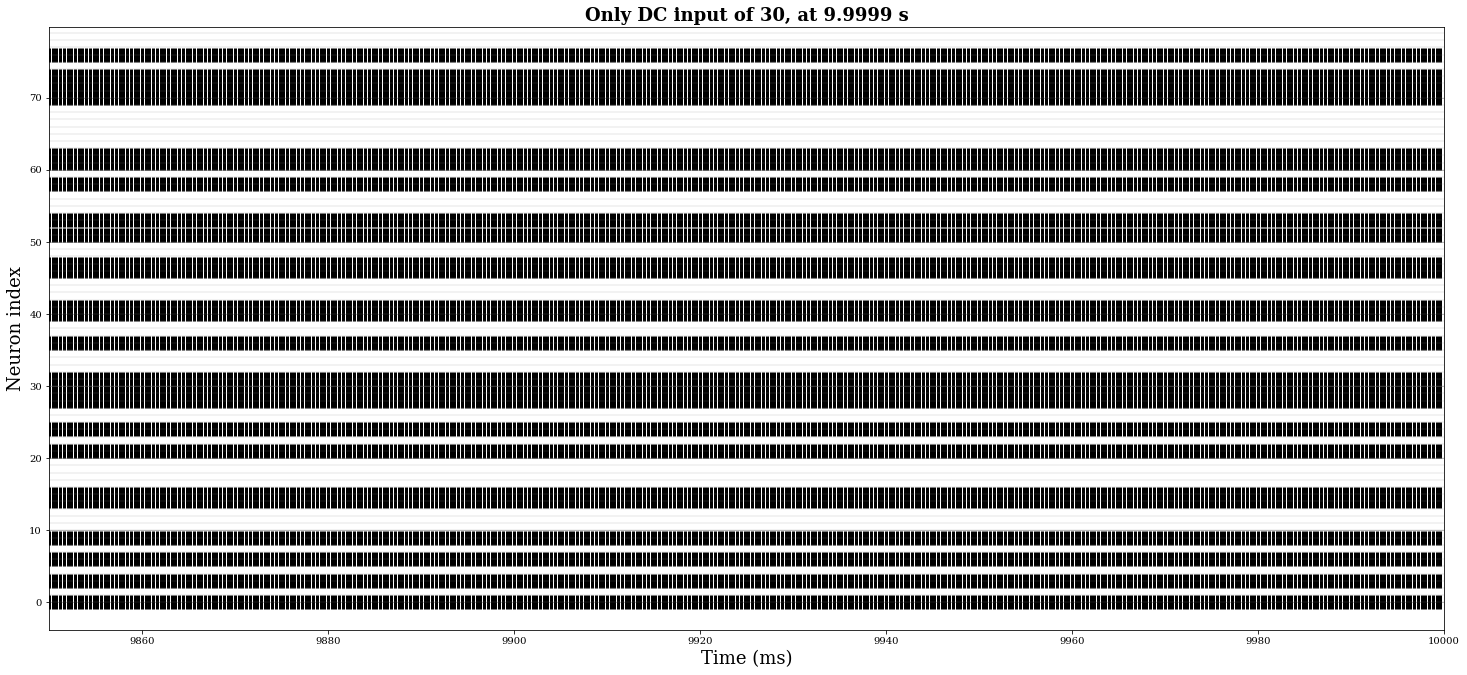

In [27]:
fig = figure(figsize=(25,15))
x_lim = (9850,10000)

gs = fig.add_gridspec(4,1)
ax=fig.add_subplot(gs[1:,:])
ax.plot(firing_time.t/ms, firing_time.i,'|k', markerfacecolor='xkcd:salmon', mew=3,markersize=14)
ax.set_xlim(x_lim)
ax.grid(True, 'both','y',linewidth=0.8,zorder=0)
for i in range(80):
    ax.axhline(y=i, linewidth=0.2, color='gray')
csfont = {'fontname':'sans-serif'}
hfont = {'fontname':'serif'}
plt.rc('xtick', labelsize=10)
xlabel('Time (ms)',**hfont,fontsize=18)
ylabel('Neuron index',**hfont,fontsize=18)
title('Only DC input of '+str(I) +', at '+str(potential.t[-1]),fontsize=18,**hfont,fontweight="bold")
plt.savefig(results_dir +str(runnum)+ 'Final_Raster_plot.png')
#grid('on',linestyle = '--', linewidth = 2,zorder=0)
show()


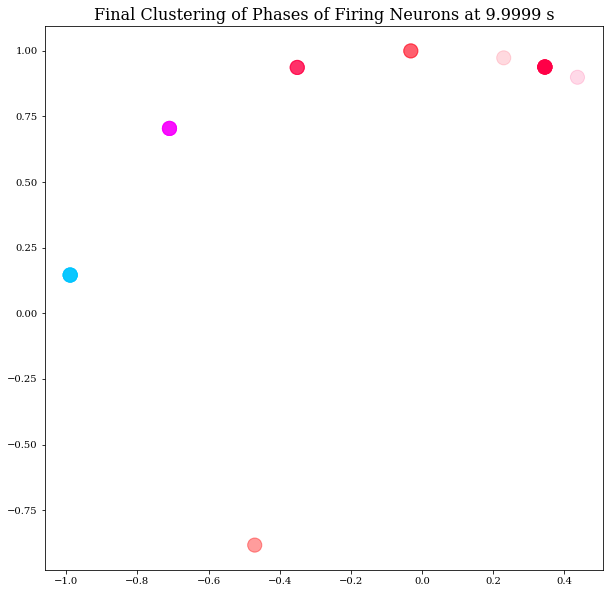

8


In [18]:
pot_arr = potential.v.copy()
pot_arr[pot_arr>1] = 1
phase = U_inv(pot_arr)

index3 = -1

sin_phase = np.sin(2*pi*phase[:,index3])
cos_phase = np.cos(2*pi*phase[:,index3])
colors=sin_phase
figure(figsize=(10,10))
scatter(cos_phase,sin_phase,c=colors, s=200, cmap='hsv', alpha=0.15)

# xlim((-1.1,1.1))
# ylim((-1.1,1.1))
plt.title('Final Clustering of Phases of Firing Neurons at ' + str(potential.t[index3]), fontsize=16)
plt.savefig(results_dir +str(runnum)+ 'Final Clustering.png')
show()
print(len(np.unique(sin_phase)))


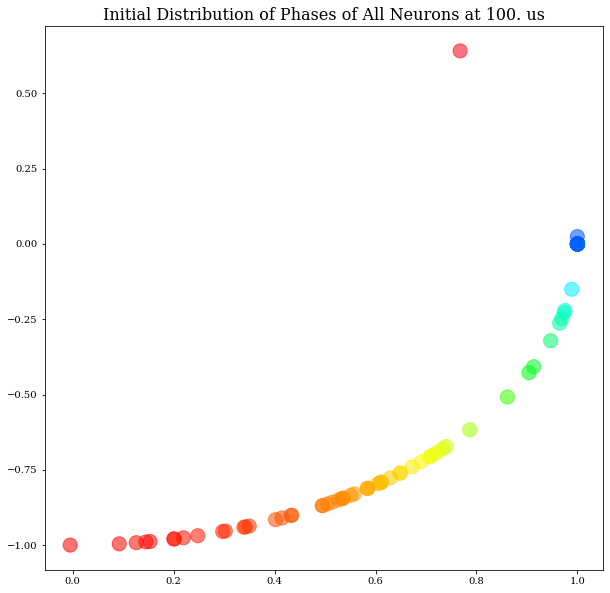

58


In [19]:
index3 = 1
sin_phase = np.sin(2*pi*phase[:,index3])
cos_phase = np.cos(2*pi*phase[:,index3])
colors=sin_phase
figure(figsize=(10,10))
scatter(cos_phase,sin_phase,c=colors, s=200, cmap='hsv', alpha=0.55)

# xlim((-1.1,1.1))
# ylim((-1.1,1.1))
plt.title('Initial Distribution of Phases of All Neurons at ' + str(potential.t[index3]), fontsize=16)
plt.savefig(results_dir +str(runnum)+ 'Initial Distribution of Phases.png')
show()
print(len(np.unique(sin_phase)))


In [20]:
def get_time_float(st):
#     print(st,type(st))
    st = format(st)
#     print(st,type(st))
    spl = st.split()
    if spl[1] == 'ms':
        return float(spl[0])
    elif spl[1] == 's':
        return float(spl[0])*1000
    else:
        return float(spl[0])/1000000
        return False
    
msecond = 1e-3
second = 1

v_values = firing_time.values('t')
indice = []
firing_data = []
# print(v_values.keys())
for i in list(v_values.keys())[:]:
#     firing_data += [[get_time_float(x),i] for x in v_values[i]]
#     n_index = i
    for x in v_values[i]:
        y=get_time_float(x)
        indice=[y,i]
        firing_data.append(indice)

#print(firing_data)
firing_data_short=np.asarray(firing_data) 
#print(firing_data_short)

firing_data_short=np.asarray(sorted(firing_data))

In [21]:
# print(firing_data_short)
import json

with open(results_dir +str(runnum)+'DC_only_firing_data_'+str(I)+'.json','w') as inf:
    json.dump(firing_data,inf)

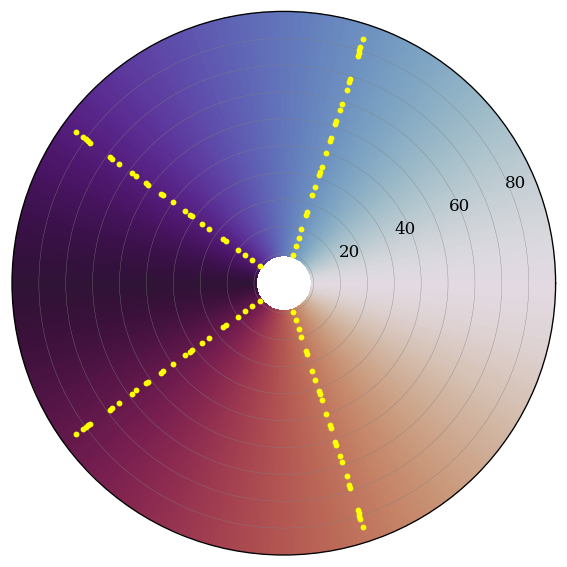

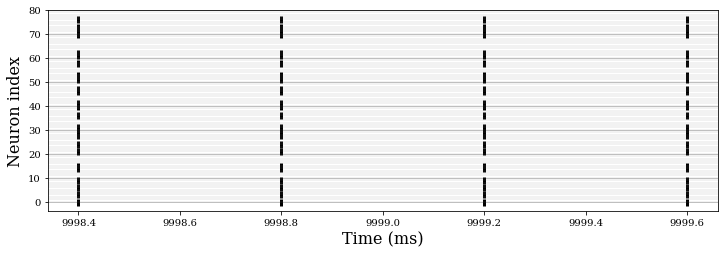

In [22]:
#At the end
low,up = 9998,10000
fir = np.asarray([x for x in firing_data_short if  x[0] > low and x[0] < up])

azimuths = np.arange(0, 361, 1)
zeniths = np.arange(9, 92, 1)
values = azimuths * np.ones((83, 361))
fig, ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'), figsize=(6,6))
ax.pcolormesh(azimuths*np.pi/180.0, zeniths, values[:-1,:-1], cmap=plt.get_cmap('twilight'))
norm_phase = ((fir[:,0])*2*np.pi)
norm_indices = (fir[:,1])+10


theta = np.arange(0,2*np.pi,0.01)
for i in range(10,91,9):
    ax.plot(theta , i*np.ones_like(theta), ls='-', lw=0.2, color='gray')
    
    

ax.plot(norm_phase, norm_indices, color='#FFFF00', marker='.',mew=2, markersize=3, ls='')
ax.set_xticks([])
# ax.set_yticks(range(10,91,10))
# ax.set_axis_on()
plt.savefig(results_dir +str(runnum)+ 'Final Firing Phase Code.png',dpi=120)
# plt.savefig(results_dir +str(runnum)+ 'Initial Firing Phase Code.png')
plt.show()
from matplotlib import cm

# Plot linear raster plot with colour coding at the bottom
raster = plt.figure(figsize=(12,5))
gs = raster.add_gridspec(4,1)
fire = raster.add_subplot(gs[:3])
fire.plot(fir[:,0], fir[:,1], '|k',mew=3,ms=7)
fire.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    fire.axhline(y=i, linewidth=0.2, color='gray')
fire.set_yticks(np.arange(0,81,10))
xlabel('Time (ms)', fontsize=16)
ylabel('Neuron index', fontsize=16)

plt.savefig(results_dir +str(runnum)+ 'Rastor_Colored_Final.png')
plt.show()

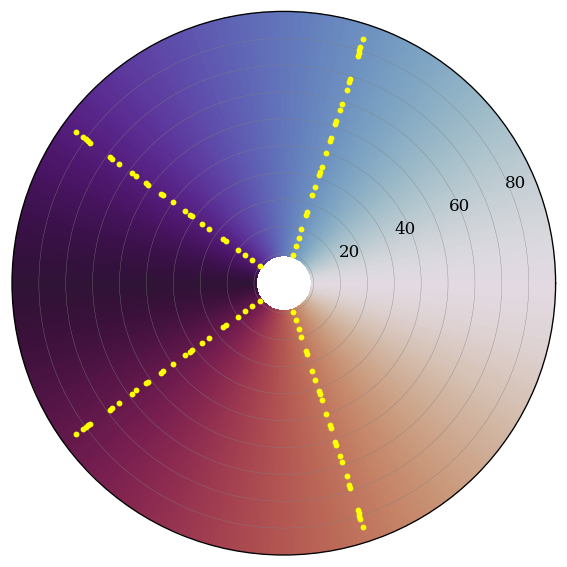

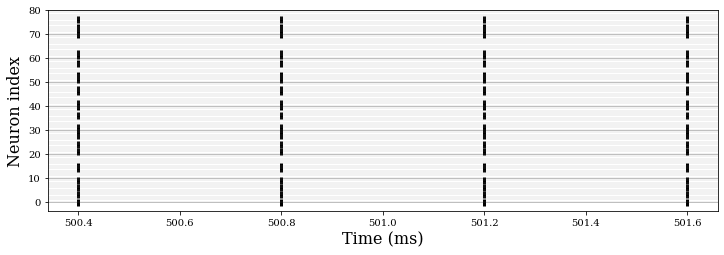

In [26]:
#In the Middle 
low,up = 500,502
k=(low,up)
fir = np.asarray([x for x in firing_data_short if  x[0] > low and x[0] < up])
azimuths = np.arange(0, 361, 1)
zeniths = np.arange(9, 92, 1)
values = azimuths * np.ones((83, 361))
fig, ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'), figsize=(6,6))
ax.pcolormesh(azimuths*np.pi/180.0, zeniths, values[:-1,:-1], cmap=plt.get_cmap('twilight'))
norm_phase = ((fir[:,0])*2*np.pi)
norm_indices = (fir[:,1])+10

theta = np.arange(0,2*np.pi,0.01)
for i in range(10,91,9):
    ax.plot(theta , i*np.ones_like(theta), ls='-', lw=0.2, color='gray')
    
    

ax.plot(norm_phase, norm_indices, color='#FFFF00', marker='.',mew=2, markersize=3, ls='')
ax.set_xticks([])
# plt.savefig(results_dir +str(runnum)+ 'Final Firing Phase Code.png',dpi=120)
plt.savefig(results_dir +str(runnum)+ 'Mid Firing Phase Code.png',dpi=120)
plt.show()

# Plot linear raster plot with colour coding at the bottom
raster = plt.figure(figsize=(12,5))
gs = raster.add_gridspec(4,1)
xlim = k

fire = raster.add_subplot(gs[:3])
fire.plot(fir[:,0], fir[:,1], '|k',mew=3,ms=7)
fire.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    fire.axhline(y=i, linewidth=0.2, color='gray')
fire.set_yticks(np.arange(0,81,10))
xlabel('Time (ms)', fontsize=16)
ylabel('Neuron index', fontsize=16)

plt.savefig(results_dir +str(runnum)+ 'Rastor_Colored_Mid.png',dpi=120)
plt.show()

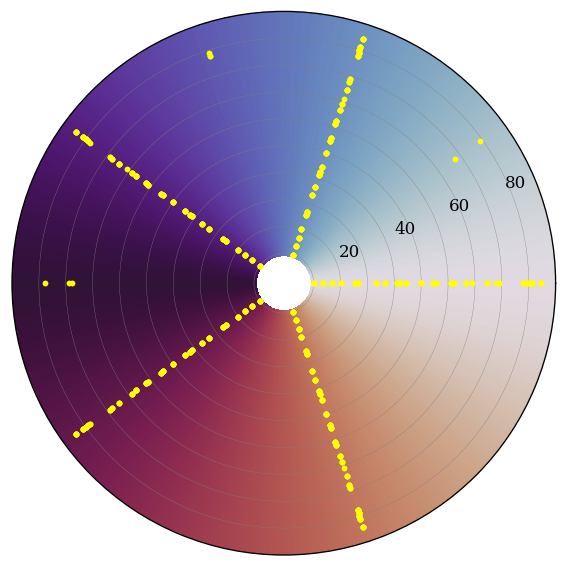

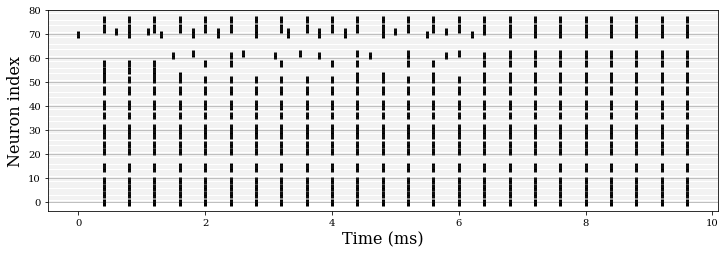

In [24]:
#Initial 
low,up = 0,10
k=(low,up)
fir = np.asarray([x for x in firing_data_short if  x[0] > low and x[0] < up])
azimuths = np.arange(0, 361, 1)
zeniths = np.arange(9, 92, 1)
values = azimuths * np.ones((83, 361))
fig, ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'), figsize=(6,6))
ax.pcolormesh(azimuths*np.pi/180.0, zeniths, values[:-1,:-1], cmap=plt.get_cmap('twilight'))
norm_phase = ((fir[:,0])*2*np.pi)
norm_indices = (fir[:,1])+10

theta = np.arange(0,2*np.pi,0.01)
for i in range(10,91,9):
    ax.plot(theta , i*np.ones_like(theta), ls='-', lw=0.2, color='gray')
    
    

ax.plot(norm_phase, norm_indices, color='#FFFF00', marker='.',mew=2, markersize=3, ls='')
ax.set_xticks([])
# plt.savefig(results_dir +str(runnum)+ 'Final Firing Phase Code.png',dpi=120)
plt.savefig(results_dir +str(runnum)+ 'Mid Firing Phase Code.png',dpi=120)
plt.show()

# Plot linear raster plot with colour coding at the bottom
raster = plt.figure(figsize=(12,5))
gs = raster.add_gridspec(4,1)
xlim = k

fire = raster.add_subplot(gs[:3])
fire.plot(fir[:,0], fir[:,1], '|k',mew=3,ms=7)
fire.grid(True, 'both','y',linewidth=0.7)
for i in range(80):
    fire.axhline(y=i, linewidth=0.2, color='gray')

fire.set_yticks(np.arange(0,81,10))
xlabel('Time (ms)', fontsize=16)
ylabel('Neuron index', fontsize=16)

plt.savefig(results_dir +str(runnum)+ 'Rastor_Colored_Mid.png',dpi=120)
plt.show()

In [25]:
# low,up = 24980,25000
# # low,up = 0,20
# fir = np.asarray([x for x in firing_data_short if  x[0] > low and x[0] < up])
# sudoku=[]
# group=[]
# # spc_group=[]
# # low,up = 0,20
# for t in (24990,25000):
# #     k=2.4998e+04
#     for x in fir:
#           if x[0]==t :
#                 print('For specific t'+str(t),x[1])#contains indices at a specific time point
# #     print([p[1] for p in sudoku])

#                 spc_group.append(x[1]) 
#           print('For specific t'+str(t),spc_group)
# #     for y in sudoku:
# #         print(y[1])
#         spc_group.append(y[1])
#         print(spc_group)
#     group.append(spc_group)
#     print('This is for 1 t'+str(t),group)
            
    

# grp=np.asarray(group) 
#print(group)